__Purpose:__ Algorithms frozen in time (2/17/23), ones that do not work and I don't know why.  These are all super low priority so I'm saving them here for "later".

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

In [2]:
from experiment_params import *
from simulations import *
import time
import pickle
from sklearn.decomposition import PCA

In [3]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


## Load Our Data In

In [4]:
'''
cond0_dict_list = [0]*num_participants
for idx in range(num_participants):
    cond0_dict_list[idx] = {'training':emgs_block1[keys[idx]][0,:,:], 'labels':refs_block1[keys[idx]][0,:,:]}

with open(path+cond0_filename, 'wb') as fp:
    pickle.dump(cond0_dict_list, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
init_decoders = [Ws_block1[keys[i]][:, 0, :, :] for i in range(num_participants)]
with open(path+all_decs_init_filename, 'wb') as fp:
    pickle.dump(init_decoders, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''
0

0

# Create Federated Set Up

In [5]:
class ModelBase:
    # Hard coded attributes --> SHARED FOR THE ENTIRE CLASS
    num_updates = 19
    cphs_starting_update = 10
    update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]
    
    def __init__(self, ID, w, method, smoothbatch=1, verbose=False, PCA_comps=7, current_round=0):
        self.type = 'Base'  # This gets overwritten but is required for __repr__ below
        self.ID = ID
        self.w = w  # Linear regression weights AKA the decoder
        self.w_prev = copy.copy(w)
        self.dec_log = [w]
        self.local_error_log = []
        self.global_error_log = []
        self.personalized_error_log = []
        self.method = method
        self.current_round = current_round
        self.verbose = verbose
        self.smoothbatch = smoothbatch
        
        self.PCA_comps = PCA_comps
        self.pca_channel_default = 64  # When PCA_comps equals this, DONT DO PCA
        if self.w.shape!=(2, self.PCA_comps):
            print(f"Class BaseModel: Overwrote the provided init decoder: {self.w.shape} --> {(2, self.PCA_comps)}")
            self.w = np.random.rand(2, self.PCA_comps)
            self.w_prev = copy.copy(self.w)
        
    def __repr__(self): 
        return f"{self.type}{self.ID}"
    
    def display_info(self): 
        return f"{self.type} model: {self.ID}\nCurrent Round: {self.current_round}\nTraining Method: {self.method}"

In [6]:
class TrainingMethods:
    # Different training approaches
    
    # This one blows up to NAN/overflow... not sure why
    def train_eta_gradstep(self, w, eta, F, D, H, V, learning_batch, alphaF, alphaD, PCA_comps):
        grad_cost = np.reshape(gradient_cost_l2(F, D, H, V, learning_batch, alphaF, alphaD, Ne=PCA_comps),(2, PCA_comps))
        w_new = w - eta*grad_cost
        return w_new

    def train_eta_scipyminstep(self, w, eta, F, D, H, V, learning_batch, alphaF, alphaD, D0, display_info, PCA_comps, full=False):
        # I turned off display_info because it's kind of annoying
        if full:
            out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps))#, options={'disp': display_info})
        else:
            out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), options={'maxiter':eta}) #'disp': display_info, 
        w_new = np.reshape(out.x,(2, PCA_comps))
        return w_new

In [7]:
class Server(ModelBase):
    def __init__(self, ID, D0, method, all_clients, smoothbatch=1, C=0.1, current_round=0, PCA_comps=7, verbose=False):
        super().__init__(ID, D0, method, smoothbatch=smoothbatch, current_round=current_round, PCA_comps=PCA_comps, verbose=verbose)
        self.type = 'Server'
        self.num_avail_clients = 0
        self.available_clients_lst = [0]*len(all_clients)
        self.num_chosen_clients = 0
        self.chosen_clients_lst = [0]*len(all_clients)
        self.all_clients = all_clients
        self.C = C  # Fraction of clients to use each round
        
        self.set_available_clients_list(init=True)
        
    # 0: Main Loop
    def execute_FL_loop(self):
        # Update global round number
        self.current_round += 1
        
        if self.method=='FedAvg':
            # Choose fraction C of available clients
            self.set_available_clients_list()
            self.choose_clients()
            # Send those clients the current global model
            for my_client in self.chosen_clients_lst:
                my_client.global_w = self.w
            # Let those clients train (this autoselects the chosen_client_lst to use)
            self.train_client_and_log(client_set=self.chosen_clients_lst)
            # AGGREGATION
            self.w_prev = copy.copy(self.w)
            self.agg_local_weights()  # This func sets self.w, eg the new decoder
            # GLOBAL SmoothBatch
            #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
            self.w = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.w_prev)
            #^ Note when self.smoothbatch=1 (default), we just keep the new self.w (no mixing)
        elif self.method=='NoFL':
            self.train_client_and_log(client_set=self.all_clients)
        else:
            print('Method not currently supported')
            print('Please reset method to FedAvg')
        # Save the new decoder to the log
        self.dec_log.append(self.w)
        # Reset all clients so no one is chosen for the next round
        for my_client in self.available_clients_lst:
            my_client.reset_chosen()
        
    # 1.1
    def set_available_clients_list(self, init=False):
        self.num_avail_clients = 0
        self.available_clients_lst = [0]*len(self.all_clients)
        for idx, my_client in enumerate(self.all_clients):
            if my_client.availability:
                self.available_clients_lst[idx] = my_client
                self.num_avail_clients += 1
                if init:
                    #if self.method != 'NoFL':
                    # Pass down the global METHOD (NOT THE WEIGHTS!!)
                    my_client.global_method = self.method
    
    # 1.2
    def choose_clients(self):
        # Check what client are available this round
        self.set_available_clients_list()
        # Now choose frac C clients from the resulting available clients
        if self.num_avail_clients > 0:
            self.num_chosen_clients = int(np.ceil(self.num_avail_clients*self.C))
            # Right now it chooses 2 at random: 14*.1=1.4 --> 2
            self.chosen_clients_lst = random.sample(self.available_clients_lst, len(self.available_clients_lst))[:self.num_chosen_clients]
            for my_client in self.chosen_clients_lst:
                my_client.chosen_status = 1
        else:
            print(f"ERROR: Number of available clients must be greater than 0: {self.num_avail_clients}")
        
    # 2
    def train_client_and_log(self, client_set):
        current_local_lst = []
        current_global_lst = []
        for my_client in client_set:
            my_client.execute_training_loop()
            current_local_lst.append((my_client.ID, my_client.eval_model(which='local')))
            if self.method != 'NoFL':
                current_global_lst.append((my_client.ID, my_client.eval_model(which='global')))
        # Append (ID, COST) to SERVER'S error log.  Note that round is implicit, it is just the index of the error log
        self.local_error_log.append(current_local_lst)
        if self.method != 'NoFL':
            # NoFL case has no global model since there's no FL
            self.global_error_log.append(current_global_lst)
    
    # 3
    def agg_local_weights(self):
        # From McMahan 2017 (vanilla FL)
        summed_num_datapoints = 0
        for my_client in self.chosen_clients_lst:
            summed_num_datapoints += my_client.learning_batch
        # Aggregate local model weights, weighted by normalized local learning rate
        aggr_w = 0
        for my_client in self.chosen_clients_lst:
            aggr_w += (my_client.learning_batch/summed_num_datapoints) * my_client.w
        self.w = aggr_w
        # Still not clear how the global decoder will be able to adapt to different channels for different orientations

In [8]:
class Client(ModelBase, TrainingMethods):
    def __init__(self, ID, w, method, local_data, data_stream, smoothbatch=1, current_round=0, PCA_comps=7, availability=1, global_method='FedAvg', eta=1, num_steps=1, delay_scaling=5, random_delays=False, download_delay=1, upload_delay=1, local_round_threshold=50, condition_number=0, verbose=False):
        super().__init__(ID, w, method, smoothbatch=smoothbatch, current_round=current_round, PCA_comps=PCA_comps, verbose=verbose)
        '''
        Note self.smoothbatch gets overwritten according to the condition number!  If you want NO smoothbatch then set it to 'off'
        '''
        # NOT INPUT
        self.type = 'Client'
        self.chosen_status = 0
        # Sentinel Values
        self.F = None
        self.V = None
        self.D = None
        self.H = np.zeros((2,2))
        self.learning_batch = None
        self.dt = 1.0/60.0
        self.eta = eta
        self.training_data = local_data['training']
        self.labels = local_data['labels']
        # Round minimization output to the nearest int or keep as a float?  Don't need arbitrary precision
        self.round2int = False
        # FL CLASS STUFF
        # Availability for training
        self.availability = availability
        # Toggle streaming aspect of data collection: {Ignore updates and use all the data; Stream each update, moving to the next update after local_round_threshold iters have been run; After 1 iteration, move to the next update}
        self.data_stream = data_stream  # {'full_data', 'streaming', 'advance_each_iter'} 
        # Number of gradient steps to take when training (eg amount of local computation)
        self.num_steps = num_steps
        # GLOBAL STUFF
        self.global_w = None
        self.global_method = global_method
        # UPDATE STUFF
        if self.global_method=='NoFL':
            starting_update = 0
        else:
            starting_update = self.cphs_starting_update
        self.current_update = starting_update
        self.local_round_threshold = local_round_threshold
        self.current_threshold = local_round_threshold
        #
        # Not even using the delay stuff right now
        # Boolean setting whether or not up/download delays should be random or predefined
        self.random_delays = random_delays
        # Scaling from random [0,1] to number of seconds
        self.delay_scaling = delay_scaling
        # Set the delay times
        if self.random_delays: 
            self.download_delay = random.random()*self.delay_scaling
            self.upload_delay = random.random()*self.delay_scaling
        else:
            self.download_delay = download_delay
            self.upload_delay = upload_delay
        #
        # ML Parameters / Conditions
        # This should probably be a dictionary at some point
        if condition_number==0:
            self.smoothbatch = 0.25
            self.alphaF = 1e-7
            self.alphaD = 1e-3
        else:
            print("That condition number is not yet supported")
        if smoothbatch=='off':
            self.smoothbatch = 1  # AKA Use only the new dec, no mixing
         
    # 0: Main Loop
    def execute_training_loop(self):
        self.simulate_data_stream()
        self.train_model()
        local_loss = self.eval_model(which='local')
        # Append (ROUND, COST) to the CLIENT error log
        self.local_error_log.append((self.current_round, local_loss))
        if self.global_method!="NoFL":
            global_loss = self.eval_model(which='global')
            # Append (ROUND, COST) to the CLIENT error log
            self.global_error_log.append((self.current_round, global_loss))
        
    def simulate_delay(self, incoming):
        if incoming:
            time.sleep(self.download_delay+random.random())
        else:
            time.sleep(self.upload_delay+random.random())
            
    def simulate_data_stream(self):
        self.current_round += 1
        if self.current_update==17:
            #print("Maxxed out your update (you are on update 19), continuing training on last update only")
            # Probably ought to track that we maxed out
            #lower_bound = update_ix[-2]  # Used to be 0 (e.g. full dataset instead of last update), saw bad behaviour...
            lower_bound = (update_ix[-2] + update_ix[-1])//2  #Use only the second half of each update
            upper_bound = update_ix[-1]
            self.learning_batch = upper_bound - lower_bound
        elif self.data_stream=='full_data':
            #print("FULL")
            lower_bound = update_ix[0]  # Starts at 0 and not update 10, for now
            upper_bound = update_ix[-1]
            self.learning_batch = upper_bound - lower_bound
        elif self.data_stream=='streaming':
            #print("STREAMING")
            if self.current_round >= self.current_threshold:
                # This had weird behaviour, error increased after first two updates...
                # Switching back to it
                self.current_threshold += self.local_round_threshold
                #self.current_threshold += self.current_threshold
                self.current_update += 1
                if self.verbose==True and self.ID==1:
                    print(f"Client {self.ID}: New update after lrt passed: (new update, current round): {self.current_update, self.current_round}")
                    print()
            #lower_bound = update_ix[self.current_update]
            lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  #Use only the second half of each update
            upper_bound = update_ix[self.current_update+1]
            self.learning_batch = upper_bound - lower_bound
        elif self.data_stream=='advance_each_iter':
            #print("ADVANCE")
            #lower_bound = update_ix[self.current_update]
            lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  #Use only the second half of each update
            upper_bound = update_ix[self.current_update+1]
            self.learning_batch = upper_bound - lower_bound
            self.current_update += 1
        else:
            raise ValueError('This data streaming functionality is not supported')
            
        s_temp = self.training_data[lower_bound:upper_bound,:]
        if self.PCA_comps!=self.pca_channel_default:  # Do PCA unless it is set to 64, AKA just the num channels
            pca = PCA(n_components=self.PCA_comps)
            s_temp = pca.fit_transform(s_temp)
        s = np.transpose(s_temp)
        v_actual = self.w@s
        p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
        p_reference = np.transpose(self.labels[lower_bound:upper_bound,:])
        # Now set the values used in the cost function
        self.F = s[:,:-1] # note: truncate F for estimate_decoder
        self.V = (p_reference - p_actual)*self.dt
        self.D = copy.copy(self.w)
    
    def train_model(self):
        D_0 = self.w_prev
        # Set the w_prev equal to the current w:
        self.w_prev = copy.copy(self.w)
        if self.global_method!="NoFL":
            # Overwrite local model with the new global model
            self.w = self.global_w
        for i in range(self.num_steps):
            if self.method=='EtaGradStep':
                self.w = self.train_eta_gradstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, PCA_comps=self.PCA_comps)
            elif self.method=='EtaScipyMinStep':
                self.w = self.train_eta_scipyminstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D_0, self.verbose, PCA_comps=self.PCA_comps)
            elif self.method=='FullScipyMinStep':
                self.w = self.train_eta_scipyminstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D_0, self.verbose, PCA_comps=self.PCA_comps, full=True)
            else:
                print("Unrecognized method")
        # Do SmoothBatch
        # Maybe move this to only happen after each update? Does it really need to happen every iter?
        # I'd have to add weird flags just for this in various places... put on hold for now
        #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
        self.w = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.w_prev)
        # Save the new decoder to the log
        self.dec_log.append(self.w)
    
    def reset_chosen(self):
        self.chosen_status = 0
        
    def eval_model(self, which):
        if which=='local':
            my_dec = self.w
            my_error_log = self.local_error_log
        elif which=='global':
            my_dec = self.global_w
            my_error_log = self.global_error_log
        else:
            print("Please set <which> to either local or global")
        # This line is why all costs are integers... could try and change it to 2 decimal points but I've heard that frequently doesn't work
        # Just did this so we wouldn't have the 14 decimals points it always tries to give
        if self.round2int:
            temp = np.ceil(cost_l2(self.F, my_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD))
            # Setting to int is just to catch overflow errors, for RT considerations, ints are also generally ints cheaper than floats...
            out = int(temp)
        else:
            temp = cost_l2(self.F, my_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)
            out = round(temp, 3)
        return out
        
    def test_inference(self):
        # Essentially, choose a random(?) section of data and compare how dec performs
        # Is this really any different from the eval funcs?
        
        # Would this be generating a new decoder to test on provided data, or just testing the current decoder on it?
        print("Testing Functionality Not Written Yet")
        pass

In [9]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

#pca = PCA(n_components=7)
#new_dec = pca.fit_transform(cond0_init_decs[0])
#print(new_dec.shape)
# Can't do this since 7 < min (2, 64)...

In [10]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

> __Passing in init decoders that are not (2, PCA_comps) AKA (2, 7) will result in the passed in dec getting overwritten to prevent matrix size mismatches.  Can't pass in the init dec from CPHS now because of PCA (unless you turn PCA off of course)__.

## 10 Steps

In [12]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvg', user_c0_10scipy)

big_loop_iters = 1000
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_10scipy.execute_FL_loop()
print("Complete")

Iter 0
Iter 100
Iter 200
Iter 300
Iter 400
Iter 500
Iter 600
Iter 700
Iter 800
Iter 900
Complete


Local

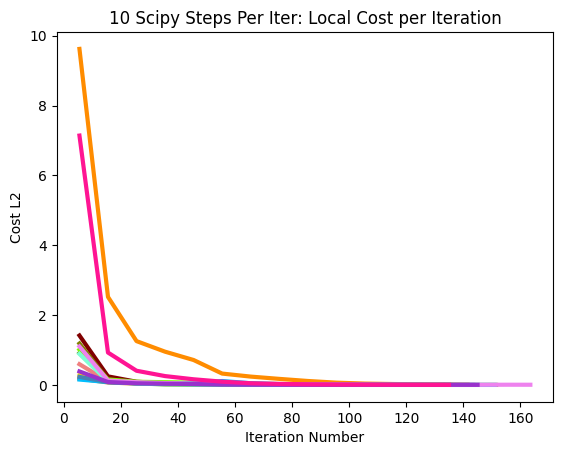

In [13]:
dim_reduc_factor = 10

for i in range(num_participants):
    #if i in (1, 3, 13):
    #    pass
    #else:
    df_local_log = pd.DataFrame(user_c0_10scipy[i].local_error_log)
    df_local_log10 = df_local_log.groupby(df_local_log.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df_local_log10.values[:, 0], df_local_log10.values[:, 1], color=id2color[i], linewidth=3)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('10 Scipy Steps Per Iter: Local Cost per Iteration')
plt.show()

Global

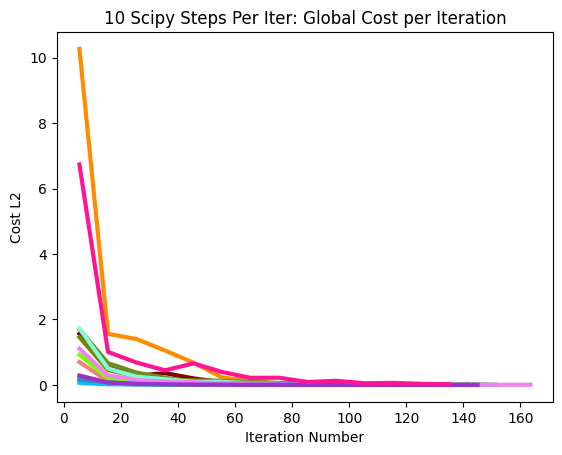

In [14]:
dim_reduc_factor = 10

for i in range(num_participants):
    #if i in (1, 3, 13):
    #    pass
    #else:
    df_global_error = pd.DataFrame(user_c0_10scipy[i].global_error_log)
    df_global_error10 = df_global_error.groupby(df_global_error.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df_global_error10.values[:, 0], df_global_error10.values[:, 1], color=id2color[i], linewidth=3)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('10 Scipy Steps Per Iter: Global Cost per Iteration')
plt.show()

## Varying Eta

1. C:\Users\kdmen\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
    - return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
1. C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:43: RuntimeWarning: overflow encountered in square
    - e = ( np.sum((D@F + H@Vminus - Vplus)\*\*2)\*(alphaE) #/ (Nd\*Nt)
1. C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:44: RuntimeWarning: overflow encountered in square
    - \+ alphaD\*np.sum(D\*\*2) #/ (Nd\*Ne)

In [15]:
user_c0_eta10 = [Client(i, D_0_7, 'EtaGradStep', cond0_training_and_labels_lst[i], 'streaming', eta=10, delay_scaling=0) for i in range(14)]
global_model_eta10 = Server(3, D_0_7, 'FedAvg', user_c0_eta10)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_eta10.execute_FL_loop()
print("Complete")

Iter 0
Iter 100
Iter 200


C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\kdmen\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\kdmen\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overfl

Iter 300


C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

Iter 400


C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

Iter 500


C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

Iter 600


C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWarning: overflow encountered in square
  term1 = np.sum((D@F + H@Vminus - Vplus)**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\simulations.py:47: RuntimeWar

Iter 700
Iter 800
Iter 900
Complete


In [16]:
user_c0_eta10[0].w

array([[nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan]])

In [17]:
user_c0_eta10[0].D

array([[nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan]])

In [18]:
user_c0_eta10[0].F

array([[178.07693326, 178.07693326, 178.07693326, ...,  97.83210746,
         97.83210746,  97.83210746],
       [ -3.77102873,  -3.77102873,  -3.77102873, ..., -30.71733554,
        -30.71733554, -30.71733554],
       [  2.72808373,   2.72808373,   2.72808373, ...,  14.52830235,
         14.52830235,  14.52830235],
       ...,
       [ -7.78700958,  -7.78700958,  -7.78700958, ...,   3.0333762 ,
          3.0333762 ,   3.0333762 ],
       [ 18.78722684,  18.78722684,  18.78722684, ...,   2.71181724,
          2.71181724,   2.71181724],
       [ -7.96525082,  -7.96525082,  -7.96525082, ...,   2.66772184,
          2.66772184,   2.66772184]])

In [19]:
user_c0_eta10[0].V

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Local

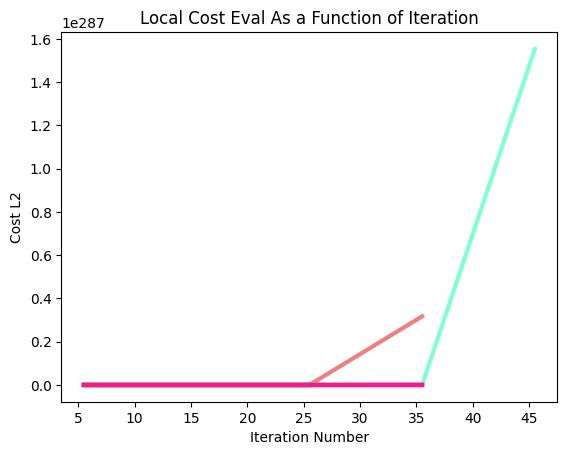

In [20]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_eta10[i].local_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=3)
           
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.show()

Global

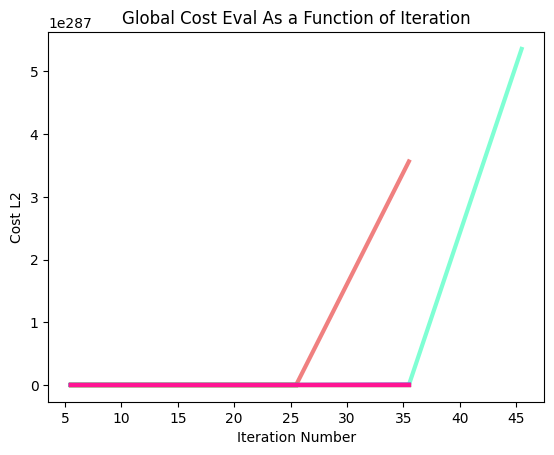

In [21]:
#dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_eta10[i].global_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    #plt.plot(my_indices, df10.values, color=id2color[i], linewidth=3)
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
plt.show()

## Full Scipy.Minimize

In [22]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model_fullscipy = Server(4, D_0_7, 'FedAvg', user_c0_fullscipy, C=1)

for i in range(18):
    if i%np.ceil(18*.1)==0:
        print(f"Iter {i}")
    global_model_fullscipy.execute_FL_loop()
print("Complete")

#cost_array = np.zeros((num_participants,17))
#for i in range(17):
#    for (client_id, error) in global_model_no_fl.local_error_log[i]:
#        cost_array[client_id, i] = error

Iter 0
Iter 2
Iter 4
Iter 6
Iter 8
Iter 10
Iter 12
Iter 14
Iter 16
Complete


Local

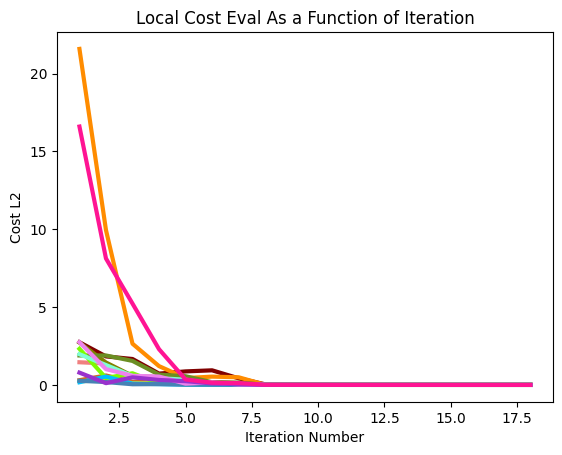

In [23]:
for i in range(num_participants):
    df = pd.DataFrame(user_c0_fullscipy[i].local_error_log)
    #my_indices = np.array(range(len(df.values)))
    #plt.plot(my_indices, df.values, color=id2color[i], linewidth=3)
    plt.plot(df.values[:, 0], df.values[:, 1], color=id2color[i], linewidth=3)
           
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.show()

Global

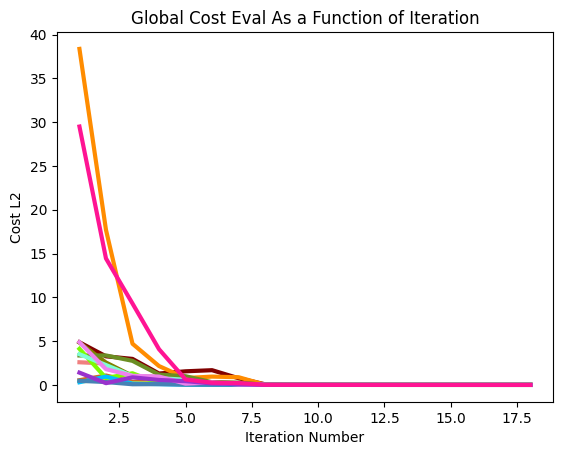

In [24]:
for i in range(num_participants):
    df = pd.DataFrame(user_c0_fullscipy[i].global_error_log)
    #my_indices = np.array(range(len(df.values)))
    #plt.plot(my_indices, df.values, color=id2color[i], linewidth=3)
    plt.plot(df.values[:, 0], df.values[:, 1], color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
plt.show()